# Middle East and North Africa clustering

The code of the DIANA algorithm is from Github and changed to fit this data. 

## Dataframe Gender

In [1]:
!pip install scikit-learn-extra

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn_extra.cluster import KMedoids
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score

In [3]:
df = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [4]:
df = df.iloc[54000:,]
df.drop(columns=df.iloc[:,3:54].columns.tolist(), inplace=True)
df.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df.rename({'Country Name':'Country'},inplace=True,axis=1)
df = df.loc[df.Indicator.str.contains('1=yes; 0=no')]
df = df.assign(Mean_GV=df.mean(axis=1, numeric_only=True))
df.drop(columns=df.iloc[:,3:16].columns.tolist(), inplace=True)
del df['Country Code']
df = pd.pivot(df, index=['Country'], columns = 'Indicator',values = 'Mean_GV')

In [5]:
importances = np.array([0.01831044, 0.03237455, 0.0031967 , 0.012108  , 0.01552896,
       0.00758614, 0.00181886, 0.0546642 , 0.01587967, 0.01247531,
       0.02007783, 0.0364012 , 0.03424009, 0.03465867, 0.02593966,
       0.01570586, 0.05781482, 0.01149065, 0.00752398, 0.05290953,
       0.07132007, 0.01305223, 0.03959353, 0.04099451, 0.02862905,
       0.00649011, 0.00942123, 0.00436768, 0.03333931, 0.02942839,
       0.02490152, 0.02989014, 0.0245622 , 0.05561928, 0.11768564])

In [6]:
df.iloc[:,] *= importances
df = df.assign(Gender_Var=df.sum(axis=1, numeric_only=True))
df.dropna(axis=0, inplace = True)
df.drop(columns=df.iloc[:,0:35].columns.tolist(), inplace=True)

## Dataframe Gini

In [7]:
df1 = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [8]:
df1 = df1.iloc[54000:,]
df1.drop(columns=df1.iloc[:,3:54].columns.tolist(), inplace=True)
df1.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df1.rename({'Country Name':'Country'},inplace=True,axis=1)
df1 = df1.loc[df1.Indicator.str.contains('Gini index')]
df1 = df1.assign(Gini_Var=df1.mean(axis=1, numeric_only=True))
df1.drop(columns=df1.iloc[:,1:16].columns.tolist(), inplace=True)
df1.dropna(axis=0, inplace = True)

## Dataframe Growth

In [9]:
df2 = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Data')

In [10]:
df2 = df2.iloc[54000:,]
df2.drop(columns=df2.iloc[:,3:54].columns.tolist(), inplace=True)
df2.rename({'Indicator Name':'Indicator'},inplace=True,axis=1)
df2.rename({'Country Name':'Country'},inplace=True,axis=1)
df2 = df2.loc[df2.Indicator.str.contains('GDP growth')]
df2 = df2.assign(Growth_Var=df2.mean(axis=1, numeric_only=True))
df2.drop(columns=df2.iloc[:,1:16].columns.tolist(), inplace=True)
df2.dropna(axis=0, inplace = True)

## Dataframe continents

In [11]:
df_Continent = pd.read_excel('./data/Gender_StatsEXCEL.xlsx',sheet_name='Country')

In [12]:
print(df_Continent['Region'].unique())

['Latin America & Caribbean' nan 'South Asia' 'Sub-Saharan Africa'
 'Europe & Central Asia' 'Middle East & North Africa'
 'East Asia & Pacific' 'North America']


In [13]:
df_Continent = df_Continent[['Table Name', 'Region']]
df_Continent.rename({'Table Name':'Country'},inplace=True,axis=1)
df_Continent.dropna(axis=0, inplace = True)

In [14]:
df_Continent['Region'].value_counts()

Europe & Central Asia         58
Sub-Saharan Africa            48
Latin America & Caribbean     42
East Asia & Pacific           37
Middle East & North Africa    21
South Asia                     8
North America                  3
Name: Region, dtype: int64

## Dataframe Gender-Growth

In [16]:
df_Gender_Growth = df.merge(df2,how='inner',left_on='Country', right_on='Country')
df_Gender_Growth = df_Gender_Growth.merge(df_Continent, how='inner',left_on='Country', right_on='Country')
df_Gender_Growth.head()

,Country,Gender_Var,Growth_Var,Region
0,Afghanistan,0.187844,2.019799,South Asia
1,Albania,0.750623,2.576940,Europe & Central Asia
2,Algeria,0.470927,2.108333,Middle East & North Africa
3,Angola,0.559647,1.527807,Sub-Saharan Africa
4,Antigua and Barbuda,0.473140,0.504912,Latin America & Caribbean


## Dataframe Gini-Growth

In [17]:
df_Gini_Growth = df1.merge(df2,how='inner',left_on='Country', right_on='Country')
df_Gini_Growth = df_Gini_Growth.merge(df_Continent, how='inner',left_on='Country', right_on='Country')
df_Gini_Growth.head()

,Country,Gini_Var,Growth_Var,Region
0,Albania,32.014286,2.576940,Europe & Central Asia
1,Algeria,27.600000,2.108333,Middle East & North Africa
2,Angola,51.300000,1.527807,Sub-Saharan Africa
3,Argentina,41.960000,1.191811,Latin America & Caribbean
4,Armenia,30.827273,3.600000,Europe & Central Asia


## Filter on Middle East and North Africa

In [18]:
df_Gender_Growth_ME = df_Gender_Growth.loc[df_Gender_Growth['Region'] == 'Middle East & North Africa']
df_Gini_Growth_ME = df_Gini_Growth.loc[df_Gini_Growth['Region'] == 'Middle East & North Africa']

In [20]:
df_Gender_Growth_ME.shape

(21, 4)

In [21]:
df_Gini_Growth_ME.shape

(14, 4)

## Gender-Growth Variable

### K-means clustering

In [60]:
df_Gender_Growth_ME_K = df_Gender_Growth_ME[['Gender_Var', 'Growth_Var']]

In [61]:
sse_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gender_Growth_ME_K)
    sse_.append([k, silhouette_score(df_Gender_Growth_ME_K, kmeans.labels_)])
sse_

[[2, 0.7284787088647772],
 [3, 0.5593011991445938],
 [4, 0.5462046657454886],
 [5, 0.48516243377133633],
 [6, 0.4802165628068677],
 [7, 0.4297060225549578],
 [8, 0.4583387718142768],
 [9, 0.40558860205318886]]

In [62]:
DB_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gender_Growth_ME_K)
    DB_.append([k, davies_bouldin_score(df_Gender_Growth_ME_K, kmeans.labels_)])
DB_

[[2, 0.39521057164880347],
 [3, 0.4763142034754185],
 [4, 0.5004241251686556],
 [5, 0.4221146200371744],
 [6, 0.41356510980482125],
 [7, 0.3324774041205064],
 [8, 0.31922315037981],
 [9, 0.40453290012224785]]

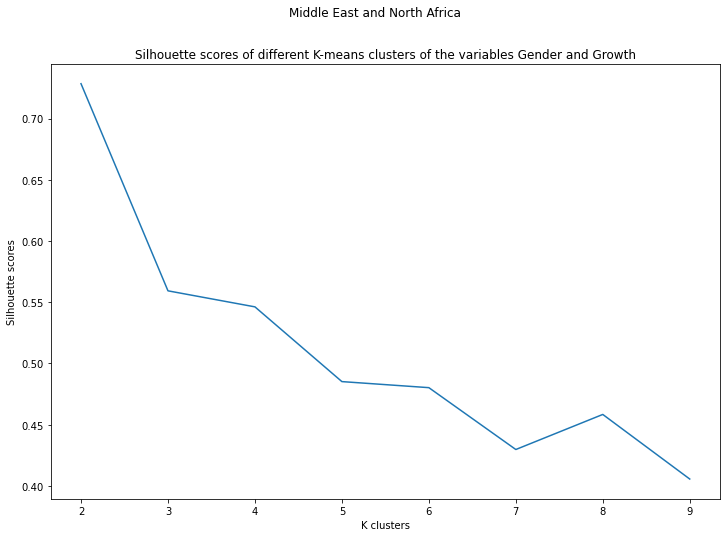

In [63]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-means clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [64]:
model_clus1 = KMeans(n_clusters = 3, random_state = 42)
model_clus1.fit(df_Gender_Growth_ME_K)
data1 = df_Gender_Growth_ME_K
data1.index = pd.RangeIndex(len(data1.index))
df_Gender_Growth_ME_K = pd.concat([data1, pd.Series(model_clus1.labels_)], axis = 1)
df_Gender_Growth_ME_K.columns = ['Gender_Var', 'Growth_Var', 'ClusterID_K']
df_Gender_Growth_ME_K['ClusterID_K'].value_counts()

0    11
2     7
1     3
Name: ClusterID_K, dtype: int64

In [65]:
df_Gender_Growth_ME = pd.merge(df_Gender_Growth_ME,  df_Gender_Growth_ME_K, how = 'inner', left_on=['Gender_Var', 'Growth_Var'], right_on=['Gender_Var', 'Growth_Var'])

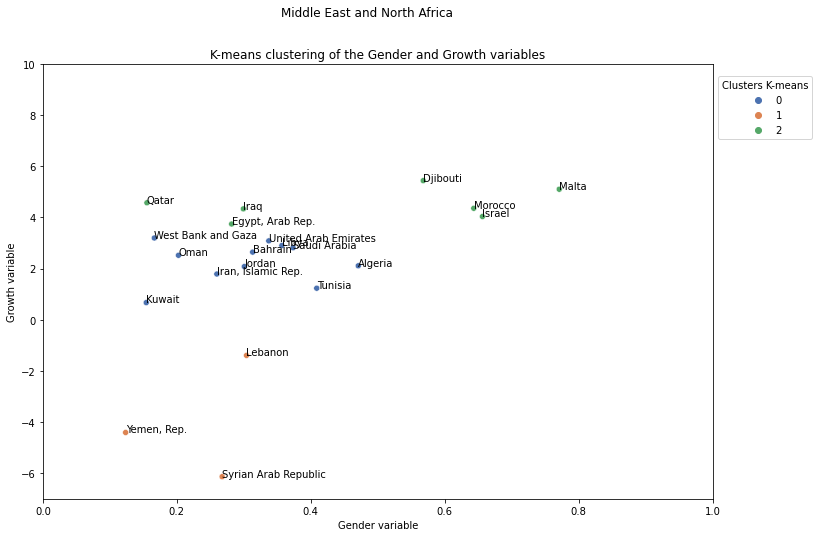

In [66]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_K', legend = 'full', palette="deep", data = df_Gender_Growth_ME)
plt.title('K-means clustering of the Gender and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_ME.Gender_Var, df_Gender_Growth_ME.Growth_Var, df_Gender_Growth_ME.Country, plt.gca()) 
plt.legend(title='Clusters K-means', loc='center left', bbox_to_anchor = (1,0.9))
plt.xlim([0,1])
plt.ylim([-7,10])
plt.show()

In [67]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_ME.groupby(['ClusterID_K']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_ME.groupby(['ClusterID_K']).Growth_Var.mean())
dt_ME_knn_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_ME_knn_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_K,,
0,0.303994,2.275790
1,0.231677,-3.979196
2,0.482152,4.511208


### K-medoids clustering

In [68]:
df_Gender_Growth_ME_KM = df_Gender_Growth_ME[['Gender_Var', 'Growth_Var']]

In [69]:
sse_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, method = 'pam', random_state = 42).fit(df_Gender_Growth_ME_KM)
    sse_.append([k, silhouette_score(df_Gender_Growth_ME_KM, kmedoids.labels_)])
sse_

[[2, 0.7284787088647772],
 [3, 0.5593011991445938],
 [4, 0.5489545126146087],
 [5, 0.4978092116714928],
 [6, 0.4375372851496208],
 [7, 0.44781874636485836],
 [8, 0.4583387718142768],
 [9, 0.4142471128120176]]

In [70]:
DB_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_Gender_Growth_ME_KM)
    DB_.append([k, davies_bouldin_score(df_Gender_Growth_ME_KM, kmedoids.labels_)])
DB_

[[2, 0.8111721810891294],
 [3, 0.4763142034754185],
 [4, 0.49822953662203984],
 [5, 0.5461852866174246],
 [6, 0.5002036466274684],
 [7, 0.47046934872454665],
 [8, 0.4583732418935626],
 [9, 0.5431885070477117]]

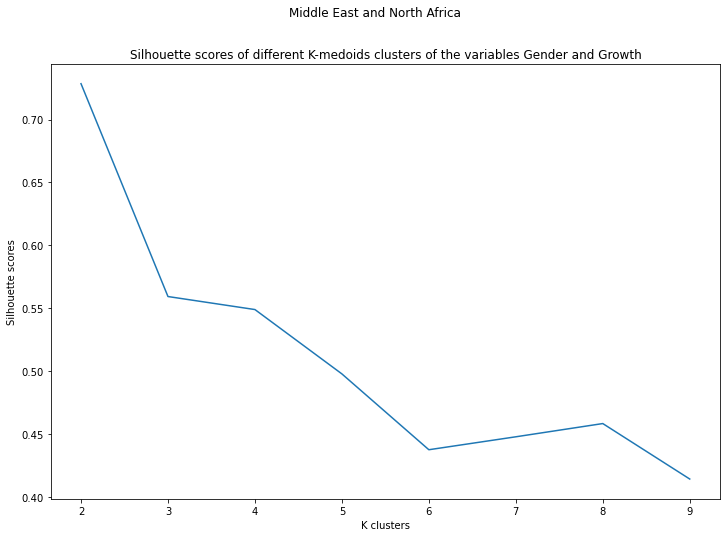

In [71]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-medoids clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [72]:
model_clus2 = KMedoids(n_clusters = 3, random_state = 42, method = 'pam')
model_clus2.fit(df_Gender_Growth_ME_KM)
data2 = df_Gender_Growth_ME_KM
data2.index = pd.RangeIndex(len(data2.index))
df_Gender_Growth_ME_KM = pd.concat([data2, pd.Series(model_clus2.labels_)], axis = 1)
df_Gender_Growth_ME_KM.columns = ['Gender_Var', 'Growth_Var', 'ClusterID_KM']
df_Gender_Growth_ME_KM['ClusterID_KM'].value_counts()

2    11
1     7
0     3
Name: ClusterID_KM, dtype: int64

In [73]:
df_Gender_Growth_ME = pd.merge(df_Gender_Growth_ME, df_Gender_Growth_ME_KM, how = 'inner', left_on=['Gender_Var', 'Growth_Var'], right_on=['Gender_Var', 'Growth_Var'])

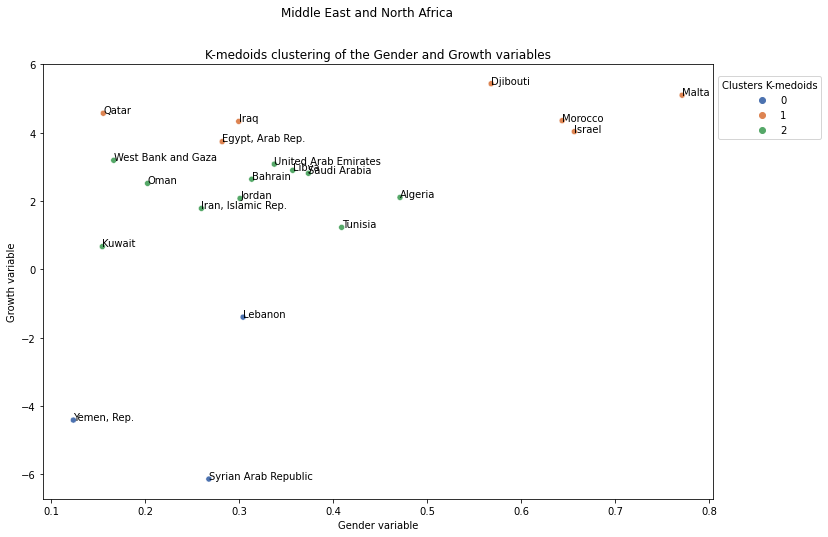

In [74]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_KM', legend = 'full', palette="deep", data = df_Gender_Growth_ME)
plt.title('K-medoids clustering of the Gender and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_ME.Gender_Var, df_Gender_Growth_ME.Growth_Var, df_Gender_Growth_ME.Country, plt.gca()) 
plt.legend(title='Clusters K-medoids', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [75]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_ME_KM.groupby(['ClusterID_KM']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_ME_KM.groupby(['ClusterID_KM']).Growth_Var.mean())
dt_ME_km_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_ME_km_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_KM,,
0,0.231677,-3.979196
1,0.482152,4.511208
2,0.303994,2.275790


### AGNES clustering

In [76]:
df_Gender_Growth_ME_A = df_Gender_Growth_ME[['Gender_Var', 'Growth_Var']]

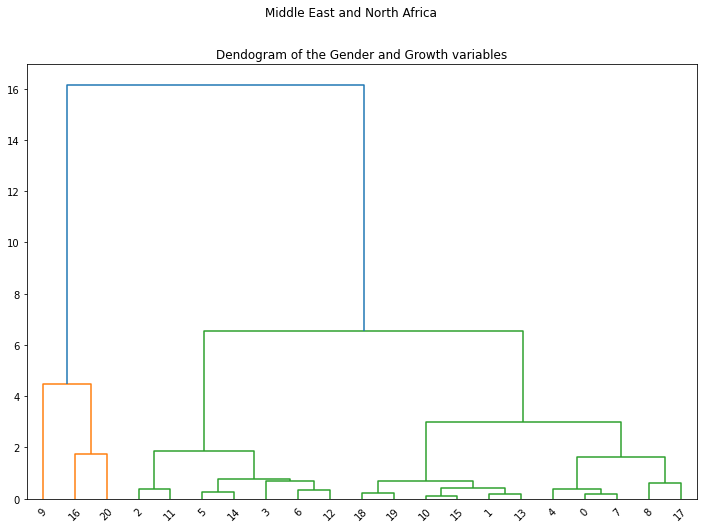

In [77]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gender and Growth variables')
plt.suptitle("Middle East and North Africa")
dend = shc.dendrogram(shc.linkage(df_Gender_Growth_ME_A, method = 'ward'))

In [78]:
sse_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gender_Growth_ME_A)
    silhouette_average = silhouette_score(df_Gender_Growth_ME_A, cluster_labels)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.7284787088647772],
 [3, 0.5593011991445938],
 [4, 0.5287433550040179],
 [5, 0.48804782540153063],
 [6, 0.4936872728167625],
 [7, 0.44317673256485257],
 [8, 0.4583387718142768],
 [9, 0.40558860205318886]]

In [79]:
DB_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gender_Growth_ME_A)
    davies_bouldin = davies_bouldin_score(df_Gender_Growth_ME_A, cluster_labels)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.39521057164880347],
 [3, 0.4763142034754185],
 [4, 0.3739685965996397],
 [5, 0.4073377223123761],
 [6, 0.4263647248068719],
 [7, 0.34784788702977754],
 [8, 0.31922315037981003],
 [9, 0.40453290012224785]]

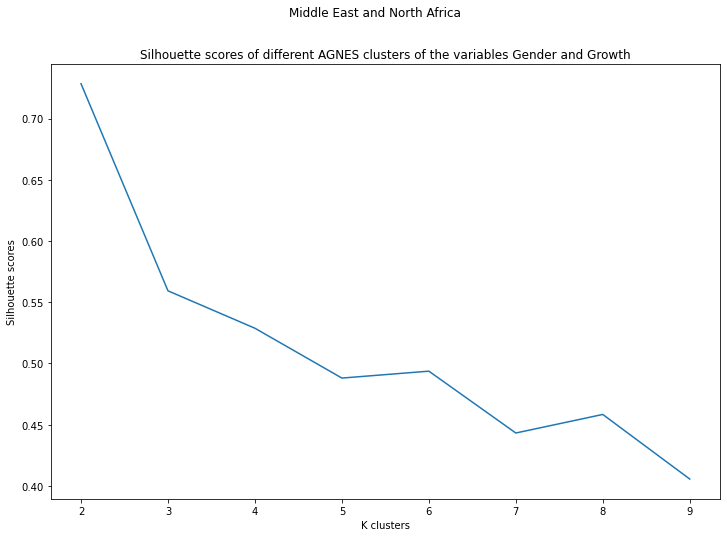

In [80]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different AGNES clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [81]:
cluster = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean' ,linkage = 'ward')
ClusterID_A = cluster.fit_predict(df_Gender_Growth_ME_A)
ClusterID_A

array([1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 0])

In [82]:
df_Gender_Growth_ME['ClusterID_A'] = [1, 1, 2, 2, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 1, 1, 0]

In [83]:
df_Gender_Growth_ME['ClusterID_A'].value_counts()

1    11
2     7
0     3
Name: ClusterID_A, dtype: int64

In [84]:
df_Gender_Growth_ME.head()

,Country,Gender_Var,Growth_Var,Region,ClusterID_K,ClusterID_KM,ClusterID_A
0,Algeria,0.470927,2.108333,Middle East & North Africa,0,2,1
1,Bahrain,0.313169,2.642933,Middle East & North Africa,0,2,1
2,Djibouti,0.567899,5.437903,Middle East & North Africa,2,1,2
3,"Egypt, Arab Rep.",0.281764,3.742290,Middle East & North Africa,2,1,2
4,"Iran, Islamic Rep.",0.259678,1.787165,Middle East & North Africa,0,2,1


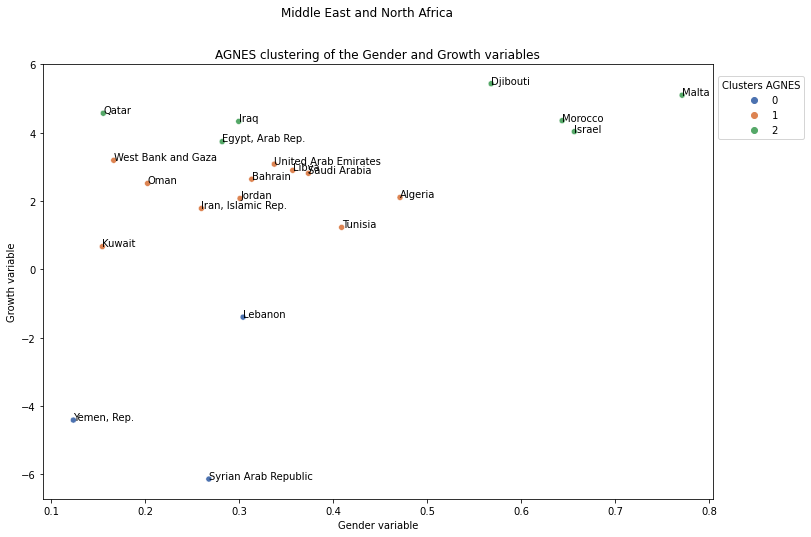

In [85]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_A', legend = 'full', palette="deep", data = df_Gender_Growth_ME)
plt.title('AGNES clustering of the Gender and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_ME.Gender_Var, df_Gender_Growth_ME.Growth_Var, df_Gender_Growth_ME.Country, plt.gca()) 
plt.legend(title='Clusters AGNES', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [86]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_ME.groupby(['ClusterID_A']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_ME.groupby(['ClusterID_A']).Growth_Var.mean())
dt_ME_A_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_ME_A_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_A,,
0,0.231677,-3.979196
1,0.303994,2.275790
2,0.482152,4.511208


### DIANA clustering

In [87]:
df_Gender_Growth_ME_D = df_Gender_Growth_ME[['Gender_Var', 'Growth_Var']]

In [88]:
from scipy.spatial import distance_matrix

def DIANA(data, n_clusters):
    n_samples = len(data)
    n_features = 2
    similarity_matrix = distance_matrix(data.values, data.values) # similarity matrix of the data
    clusters = [list(range(n_samples))]      # list of clusters, initially the whole dataset is a single cluster
    while True:
        c_diameters = [np.max(similarity_matrix[cluster][:, cluster]) for cluster in clusters]  #cluster diameters
        max_cluster_dia = np.argmax(c_diameters)  #maximum cluster diameter
        max_difference_index = np.argmax(np.mean(similarity_matrix[clusters[max_cluster_dia]][:, clusters[max_cluster_dia]], axis=1))
        splinters = [clusters[max_cluster_dia][max_difference_index]] #spinter group
        last_clusters = clusters[max_cluster_dia]
        del last_clusters[max_difference_index]
        while True:
            split = False
            for j in range(len(last_clusters))[::-1]:
                splinter_distances = similarity_matrix[last_clusters[j], splinters]
                last_distances = similarity_matrix[last_clusters[j], np.delete(last_clusters, j, axis=0)]
                if np.mean(splinter_distances) <= np.mean(last_distances):
                    splinters.append(last_clusters[j])
                    del last_clusters[j]
                    split = True
                    break
            if split == False:
                break
        del clusters[max_cluster_dia]
        clusters.append(splinters)
        clusters.append(last_clusters)
        if len(clusters) == n_clusters:
            break

    cluster_labels = np.zeros(n_samples)
    for i in range(len(clusters)):
        cluster_labels[clusters[i]] = i

    return cluster_labels

In [89]:
sse_ = []
for k in range (2,10):
    clustering = DIANA(df_Gender_Growth_ME_D, k)
    silhouette_average = silhouette_score(df_Gender_Growth_ME_D, clustering)
    sse_.append([k, silhouette_average])
sse_

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-p

[[2, 0.7284787088647772],
 [3, 0.5593011991445938],
 [4, 0.5287433550040179],
 [5, 0.4978092116714928],
 [6, 0.44729867141958285],
 [7, 0.4297060225549578],
 [8, 0.3937915566349509],
 [9, 0.36604898332118535]]

In [90]:
DB_ = []
for k in range (2,10):
    clustering = DIANA(df_Gender_Growth_ME_D, k)
    davies_bouldin = davies_bouldin_score(df_Gender_Growth_ME_D, clustering)
    DB_.append([k, davies_bouldin])
DB_

/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/conda/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.9/site-p

[[2, 0.39521057164880347],
 [3, 0.4763142034754185],
 [4, 0.37396859659963977],
 [5, 0.3959572634665203],
 [6, 0.3042895812245365],
 [7, 0.3324774041205064],
 [8, 0.3552684147282986],
 [9, 0.35307332404529085]]

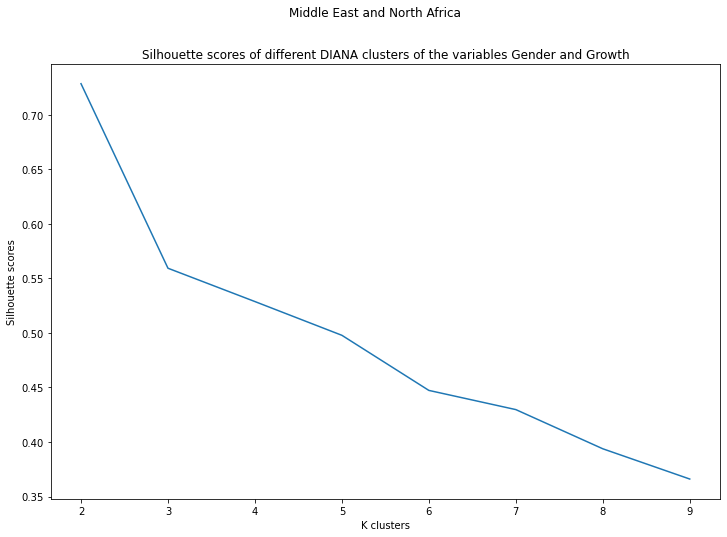

In [91]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different DIANA clusters of the variables Gender and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [92]:
DIANA(df_Gender_Growth_ME_D, 3)

array([1., 1., 2., 2., 1., 2., 2., 1., 1., 0., 1., 2., 2., 1., 2., 1., 0.,
       1., 1., 1., 0.])

In [93]:
df_Gender_Growth_ME['ClusterID_D'] = [round(float(i)) for i in [1., 1., 2., 2., 1., 2., 2., 1., 1., 0., 1., 2., 2., 1., 2., 1., 0.,
       1., 1., 1., 0.]]

In [94]:
df_Gender_Growth_ME['ClusterID_D'].value_counts()

1    11
2     7
0     3
Name: ClusterID_D, dtype: int64

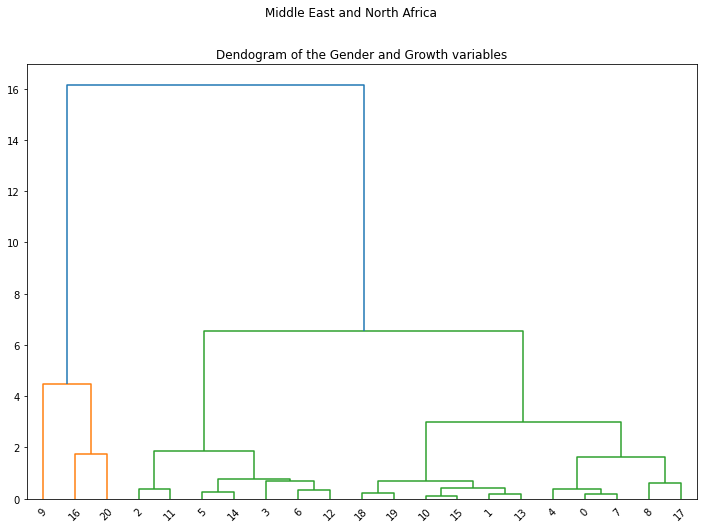

In [95]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gender and Growth variables')
plt.suptitle("Middle East and North Africa")
dend = shc.dendrogram(shc.linkage(df_Gender_Growth_ME_D, method = 'ward'))

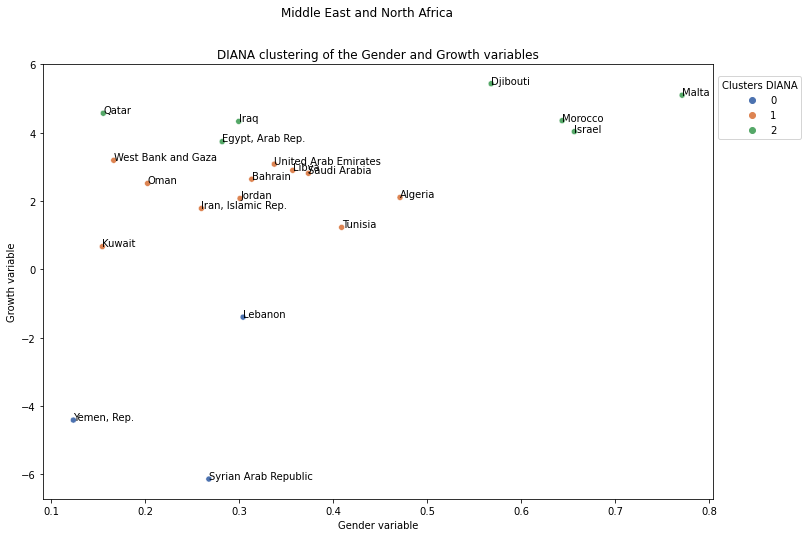

In [96]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gender_Var', y = 'Growth_Var', hue = 'ClusterID_D', legend = 'full', palette="deep", data = df_Gender_Growth_ME)
plt.title('DIANA clustering of the Gender and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gender variable")
label_point(df_Gender_Growth_ME.Gender_Var, df_Gender_Growth_ME.Growth_Var, df_Gender_Growth_ME.Country, plt.gca()) 
plt.legend(title='Clusters DIANA', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [97]:
Cluster_Gender = pd.DataFrame(df_Gender_Growth_ME.groupby(['ClusterID_D']).Gender_Var.mean())
Cluster_Growth = pd.DataFrame(df_Gender_Growth_ME.groupby(['ClusterID_D']).Growth_Var.mean())
dt_ME_D_Gender_Growth = pd.concat([Cluster_Gender, Cluster_Growth], axis = 1)
dt_ME_D_Gender_Growth

,Gender_Var,Growth_Var
ClusterID_D,,
0,0.231677,-3.979196
1,0.303994,2.275790
2,0.482152,4.511208


## Growth-Gini Variable

### K-means clustering

In [99]:
df_Gini_Growth_ME_K = df_Gini_Growth_ME[['Growth_Var', 'Gini_Var']]

In [100]:
sse_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gini_Growth_ME_K)
    sse_.append([k, silhouette_score(df_Gini_Growth_ME_K, kmeans.labels_)])
sse_

[[2, 0.5100168518101756],
 [3, 0.5293065572185272],
 [4, 0.534282998948278],
 [5, 0.48762408443641475],
 [6, 0.4829801752194716],
 [7, 0.4029598310533665],
 [8, 0.37988511210525255],
 [9, 0.32113098339907237]]

In [101]:
DB_ = []
for k in range(2,10):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(df_Gini_Growth_ME_K)
    DB_.append([k, davies_bouldin_score(df_Gini_Growth_ME_K, kmeans.labels_)])
DB_

[[2, 0.7033222439083828],
 [3, 0.6536725571160188],
 [4, 0.481529080695432],
 [5, 0.4285697825972372],
 [6, 0.29091691450910123],
 [7, 0.26983322166872176],
 [8, 0.21347838834318988],
 [9, 0.322660642188637]]

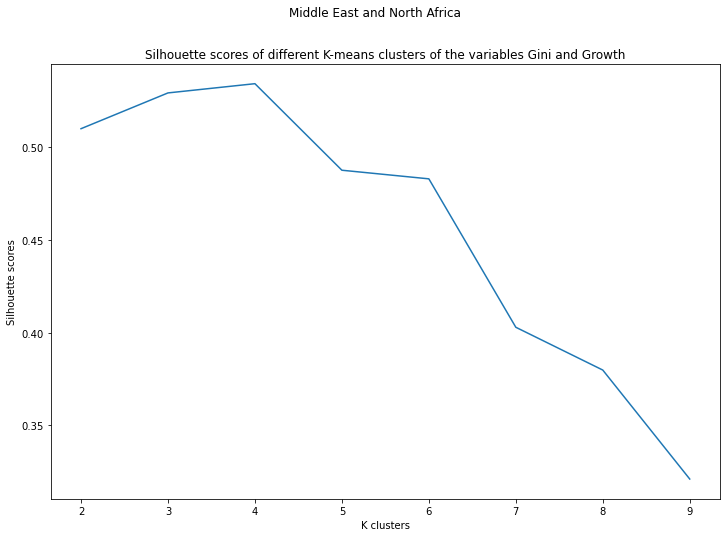

In [102]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-means clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [103]:
model_clus1 = KMeans(n_clusters = 4, random_state = 42)
model_clus1.fit(df_Gini_Growth_ME_K)
data1 = df_Gini_Growth_ME_K
data1.index = pd.RangeIndex(len(data1.index))
df_Gini_Growth_ME_K = pd.concat([data1, pd.Series(model_clus1.labels_)], axis = 1)
df_Gini_Growth_ME_K.columns = ['Growth_Var', 'Gini_Var', 'ClusterID_K']
df_Gini_Growth_ME_K['ClusterID_K'].value_counts()

0    5
1    4
2    4
3    1
Name: ClusterID_K, dtype: int64

In [104]:
df_Gini_Growth_ME = pd.merge(df_Gini_Growth_ME,  df_Gini_Growth_ME_K, how = 'inner', left_on=['Growth_Var', 'Gini_Var'], right_on=['Growth_Var', 'Gini_Var'])

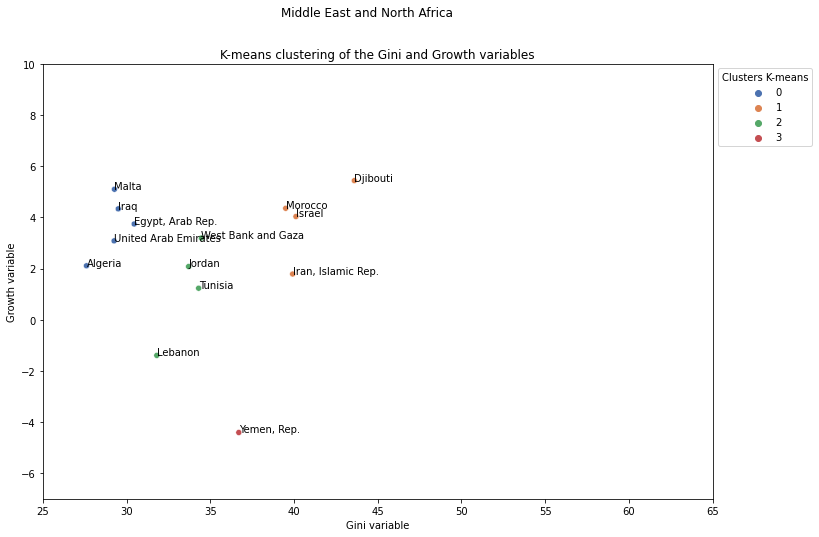

In [105]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_K', legend = 'full', palette="deep", data = df_Gini_Growth_ME)
plt.title('K-means clustering of the Gini and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_ME.Gini_Var, df_Gini_Growth_ME.Growth_Var, df_Gini_Growth_ME.Country, plt.gca()) 
plt.xlim([25,65])
plt.ylim([-7,10])
plt.legend(title='Clusters K-means', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [106]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_K']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_K']).Gini_Var.mean())
dt_ME_knn_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_ME_knn_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_K,,
0,3.673647,29.214000
1,3.904062,40.781349
2,1.277738,33.566667
3,-4.408199,36.700000


### K-medoids clustering

In [107]:
df_Gini_Growth_ME_KM = df_Gini_Growth_ME[['Growth_Var', 'Gini_Var']]

In [108]:
sse_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, method = 'pam', random_state = 42).fit(df_Gini_Growth_ME_KM)
    sse_.append([k, silhouette_score(df_Gini_Growth_ME_KM, kmedoids.labels_)])
sse_

[[2, 0.5100168518101756],
 [3, 0.5293065572185272],
 [4, 0.534282998948278],
 [5, 0.5150035228234489],
 [6, 0.4829801752194716],
 [7, 0.4029598310533665],
 [8, 0.37988511210525255],
 [9, 0.29116837126693706]]

In [109]:
DB_ = []
for k in range(2,10):
    kmedoids = KMedoids(n_clusters = k, random_state = 42).fit(df_Gini_Growth_ME_KM)
    DB_.append([k, davies_bouldin_score(df_Gini_Growth_ME_KM, kmedoids.labels_)])
DB_

[[2, 0.7033222439083828],
 [3, 0.6536725571160188],
 [4, 0.6157958479234458],
 [5, 0.6885893232273721],
 [6, 0.5906437937429397],
 [7, 0.5879426903327156],
 [8, 0.5323667878730345],
 [9, 0.5181234951685509]]

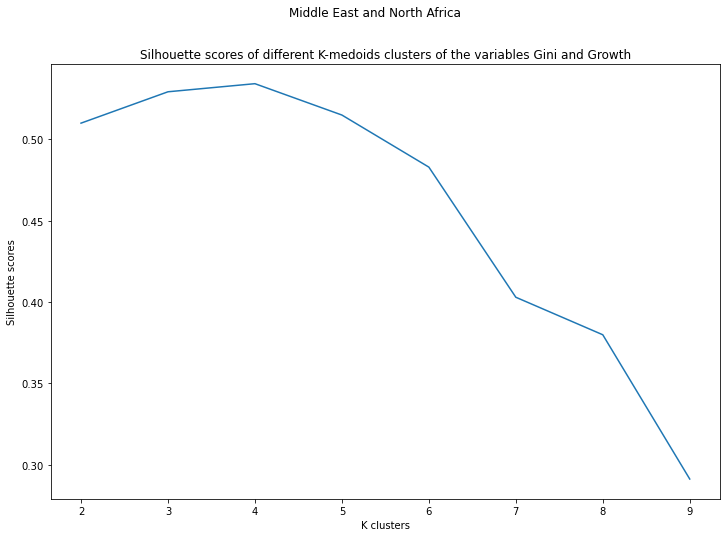

In [110]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different K-medoids clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [111]:
model_clus2 = KMedoids(n_clusters = 4, random_state = 42, method = 'pam')
model_clus2.fit(df_Gini_Growth_ME_KM)
data2 = df_Gini_Growth_ME_KM
data2.index = pd.RangeIndex(len(data2.index))
df_Gini_Growth_ME_KM = pd.concat([data2, pd.Series(model_clus2.labels_)], axis = 1)
df_Gini_Growth_ME_KM.columns = ['Growth_Var', 'Gini_Var', 'ClusterID_KM']
df_Gini_Growth_ME_KM['ClusterID_KM'].value_counts()

3    5
0    4
2    4
1    1
Name: ClusterID_KM, dtype: int64

In [112]:
df_Gini_Growth_ME = pd.merge(df_Gini_Growth_ME, df_Gini_Growth_ME_KM, how = 'inner', left_on=['Growth_Var', 'Gini_Var'], right_on=['Growth_Var', 'Gini_Var'])

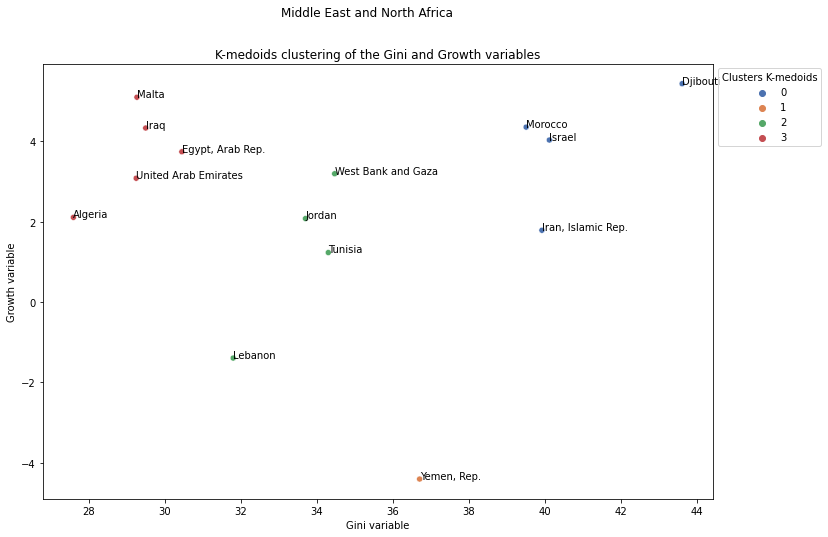

In [113]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_KM', legend = 'full', palette="deep", data = df_Gini_Growth_ME)
plt.title('K-medoids clustering of the Gini and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_ME.Gini_Var, df_Gini_Growth_ME.Growth_Var, df_Gini_Growth_ME.Country, plt.gca()) 
plt.legend(title='Clusters K-medoids',  loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [114]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_KM']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_KM']).Gini_Var.mean())
dt_ME_km_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_ME_km_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_KM,,
0,3.904062,40.781349
1,-4.408199,36.700000
2,1.277738,33.566667
3,3.673647,29.214000


### AGNES algorithm

In [115]:
df_Gini_Growth_ME_A = df_Gini_Growth_ME[['Growth_Var', 'Gini_Var']]

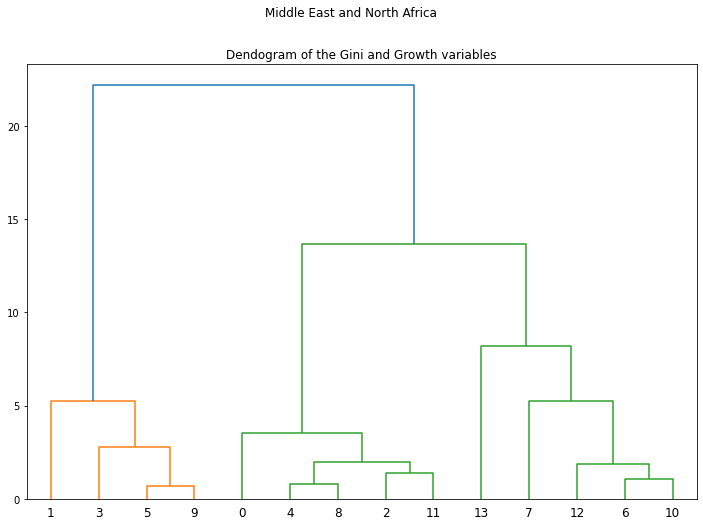

In [116]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gini and Growth variables')
plt.suptitle("Middle East and North Africa")
dend = shc.dendrogram(shc.linkage(df_Gini_Growth_ME_A, method = 'ward'))

In [117]:
sse_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gini_Growth_ME_A)
    silhouette_average = silhouette_score(df_Gini_Growth_ME_A, cluster_labels)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.5253656236699044],
 [3, 0.5293065572185272],
 [4, 0.534282998948278],
 [5, 0.48762408443641475],
 [6, 0.4829801752194716],
 [7, 0.4029598310533665],
 [8, 0.37988511210525255],
 [9, 0.32113098339907237]]

In [118]:
DB_ = []
for k in range (2,10):
    clustering = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean' ,linkage = 'ward')
    cluster_labels = clustering.fit_predict(df_Gini_Growth_ME_A)
    davies_bouldin = davies_bouldin_score(df_Gini_Growth_ME_A, cluster_labels)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.5840100124484175],
 [3, 0.6536725571160188],
 [4, 0.481529080695432],
 [5, 0.4285697825972371],
 [6, 0.29091691450910123],
 [7, 0.26983322166872176],
 [8, 0.21347838834318988],
 [9, 0.322660642188637]]

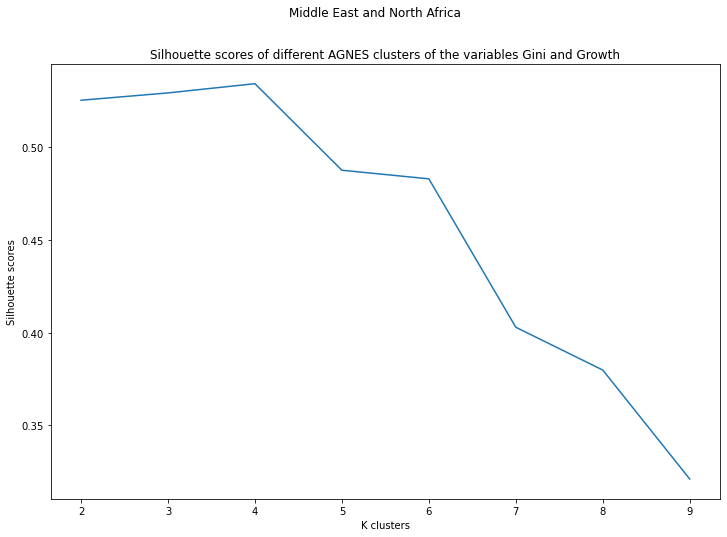

In [119]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different AGNES clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [120]:
cluster = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean' ,linkage = 'ward')
ClusterID_A = cluster.fit_predict(df_Gini_Growth_ME_A)
ClusterID_A

array([2, 0, 2, 0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 3])

In [121]:
df_Gini_Growth_ME['ClusterID_A'] = [2, 0, 2, 0, 2, 0, 1, 1, 2, 0, 1, 2, 1, 3]

In [122]:
df_Gini_Growth_ME['ClusterID_A'].value_counts()

2    5
0    4
1    4
3    1
Name: ClusterID_A, dtype: int64

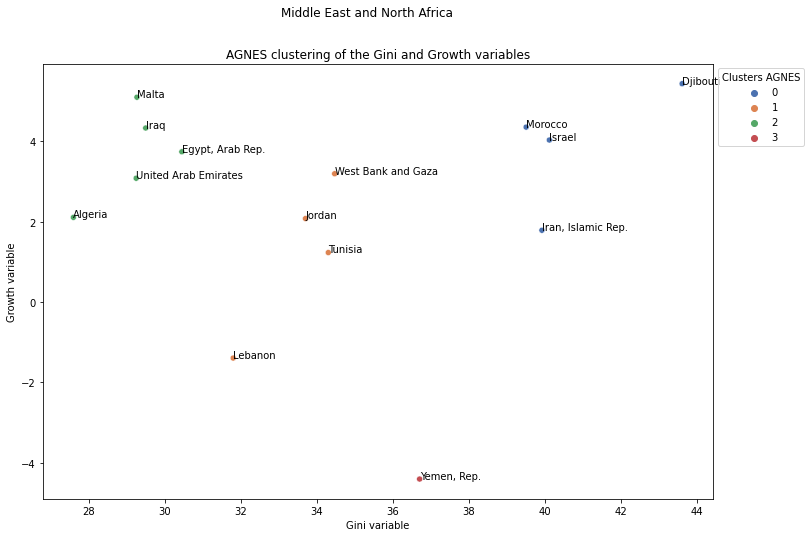

In [123]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_A', legend = 'full', palette="deep", data = df_Gini_Growth_ME)
plt.title('AGNES clustering of the Gini and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_ME.Gini_Var, df_Gini_Growth_ME.Growth_Var, df_Gini_Growth_ME.Country, plt.gca()) 
plt.legend(title='Clusters AGNES', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [124]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_A']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_A']).Gini_Var.mean())
dt_ME_A_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_ME_A_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_A,,
0,3.904062,40.781349
1,1.277738,33.566667
2,3.673647,29.214000
3,-4.408199,36.700000


### DIANA clustering

In [125]:
df_Gini_Growth_ME_D = df_Gini_Growth_ME[['Growth_Var', 'Gini_Var']]

In [126]:
from scipy.spatial import distance_matrix

def DIANA(data, n_clusters):
    n_samples = len(data)
    n_features = 2
    similarity_matrix = distance_matrix(data.values, data.values) # similarity matrix of the data
    clusters = [list(range(n_samples))]      # list of clusters, initially the whole dataset is a single cluster
    while True:
        c_diameters = [np.max(similarity_matrix[cluster][:, cluster]) for cluster in clusters]  #cluster diameters
        max_cluster_dia = np.argmax(c_diameters)  #maximum cluster diameter
        max_difference_index = np.argmax(np.mean(similarity_matrix[clusters[max_cluster_dia]][:, clusters[max_cluster_dia]], axis=1))
        splinters = [clusters[max_cluster_dia][max_difference_index]] #spinter group
        last_clusters = clusters[max_cluster_dia]
        del last_clusters[max_difference_index]
        while True:
            split = False
            for j in range(len(last_clusters))[::-1]:
                splinter_distances = similarity_matrix[last_clusters[j], splinters]
                last_distances = similarity_matrix[last_clusters[j], np.delete(last_clusters, j, axis=0)]
                if np.mean(splinter_distances) <= np.mean(last_distances):
                    splinters.append(last_clusters[j])
                    del last_clusters[j]
                    split = True
                    break
            if split == False:
                break
        del clusters[max_cluster_dia]
        clusters.append(splinters)
        clusters.append(last_clusters)
        if len(clusters) == n_clusters:
            break

    cluster_labels = np.zeros(n_samples)
    for i in range(len(clusters)):
        cluster_labels[clusters[i]] = i

    return cluster_labels

In [127]:
sse_ = []
for k in range (2,10):
    clustering = DIANA(df_Gini_Growth_ME_D, k)
    silhouette_average = silhouette_score(df_Gini_Growth_ME_D, clustering)
    sse_.append([k, silhouette_average])
sse_

[[2, 0.5253656236699044],
 [3, 0.5053347059650136],
 [4, 0.534282998948278],
 [5, 0.5150035228234489],
 [6, 0.4829801752194716],
 [7, 0.4029598310533665],
 [8, 0.37988511210525255],
 [9, 0.32113098339907237]]

In [128]:
DB_ = []
for k in range (2,10):
    clustering = DIANA(df_Gini_Growth_ME_D, k)
    davies_bouldin = davies_bouldin_score(df_Gini_Growth_ME_D, clustering)
    DB_.append([k, davies_bouldin])
DB_

[[2, 0.5840100124484175],
 [3, 0.4332731514513024],
 [4, 0.481529080695432],
 [5, 0.324231726788343],
 [6, 0.2909169145091012],
 [7, 0.26983322166872176],
 [8, 0.21347838834318988],
 [9, 0.322660642188637]]

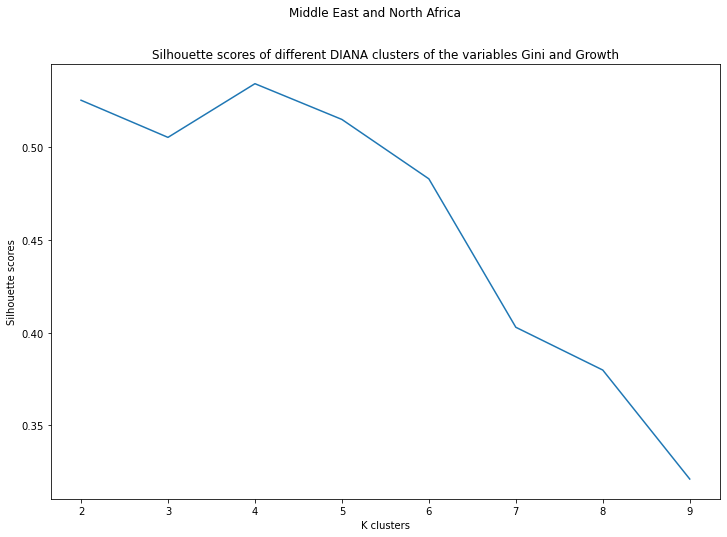

In [129]:
fig = plt.figure(figsize = (12,8))
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])
plt.title("Silhouette scores of different DIANA clusters of the variables Gini and Growth")
plt.ylabel("Silhouette scores")
plt.xlabel("K clusters")
plt.suptitle("Middle East and North Africa")
plt.show()

In [130]:
DIANA(df_Gini_Growth_ME_D, 4)

array([3., 0., 3., 0., 3., 0., 2., 2., 3., 0., 2., 3., 2., 1.])

In [131]:
df_Gini_Growth_ME['ClusterID_D'] = [round(float(i)) for i in [3., 0., 3., 0., 3., 0., 2., 2., 3., 0., 2., 3., 2., 1.]]

In [132]:
df_Gini_Growth_ME['ClusterID_D'] .value_counts()

3    5
0    4
2    4
1    1
Name: ClusterID_D, dtype: int64

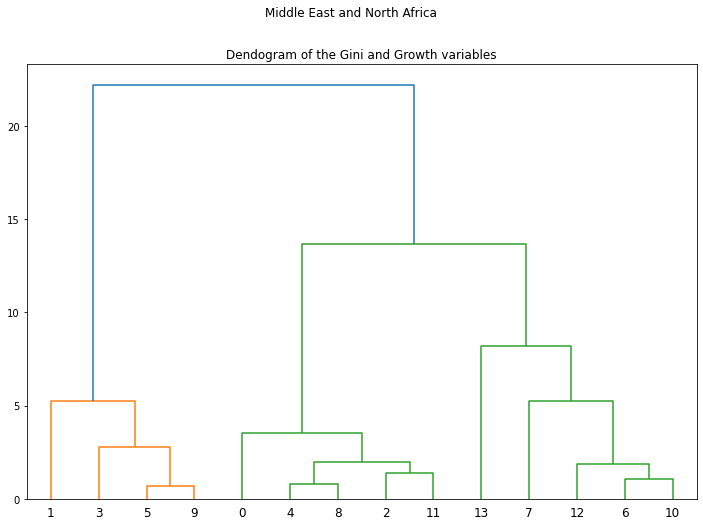

In [133]:
fig = plt.figure(figsize = (12,8))
plt.title('Dendogram of the Gini and Growth variables')
plt.suptitle("Middle East and North Africa")
dend = shc.dendrogram(shc.linkage(df_Gini_Growth_ME_D, method = 'ward'))

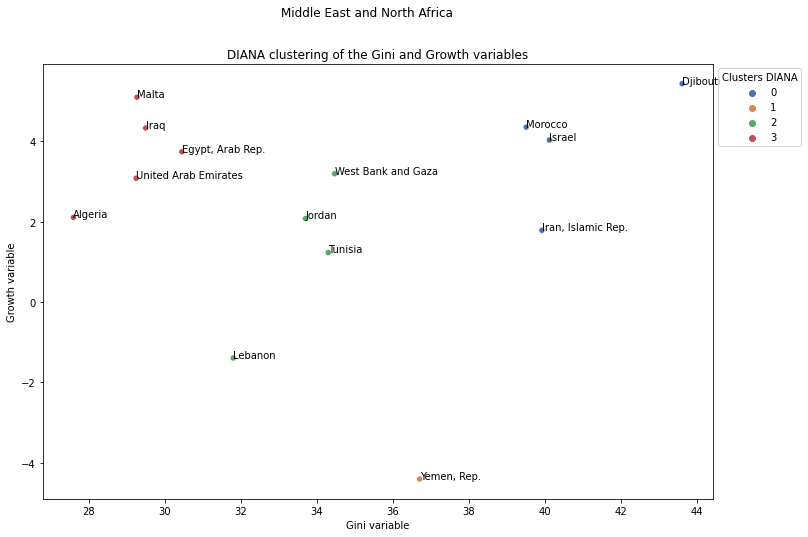

In [134]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x='Gini_Var', y = 'Growth_Var', hue = 'ClusterID_D', legend = 'full', palette="deep", data = df_Gini_Growth_ME)
plt.title('DIANA clustering of the Gini and Growth variables')
plt.suptitle("Middle East and North Africa")
plt.ylabel("Growth variable")
plt.xlabel("Gini variable")
label_point(df_Gini_Growth_ME.Gini_Var, df_Gini_Growth_ME.Growth_Var, df_Gini_Growth_ME.Country, plt.gca()) 
plt.legend(title='Clusters DIANA', loc='center left', bbox_to_anchor = (1,0.9))
plt.show()

In [135]:
Cluster_Growth = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_D']).Growth_Var.mean())
Cluster_Gini = pd.DataFrame(df_Gini_Growth_ME.groupby(['ClusterID_D']).Gini_Var.mean())
dt_ME_D_Growth_Gini = pd.concat([Cluster_Growth, Cluster_Gini], axis = 1)
dt_ME_D_Growth_Gini

,Growth_Var,Gini_Var
ClusterID_D,,
0,3.904062,40.781349
1,-4.408199,36.700000
2,1.277738,33.566667
3,3.673647,29.214000
